In [1]:
import os
import warnings
import argparse
import datetime
import pathlib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

from test import test
from utils.evaluate_uncertainty import evaluate_uncertainty
from core.config import create_config, save_config
# from core.dataset import COCODataset
from core.dataset_hotswapped import COCODataset
from core.model import Model
from core.metrics import AccuracyLogger
import pickle

In [ ]:
with open('args_parseargs.p','rb') as F:
    args = pickle.load(F)

In [ ]:
args.annotations='../openrooms/annotation_files/main_xml1_non_paired_removed_train.json'

In [ ]:
material_fols = ['main_xm1_arbitrary_Starry','main_xm1_arbitrary_candy']

In [ ]:
# Creatematerial_folderst directory
pathlib.Path(args.outdir).mkdir(exist_ok=True, parents=True)

# Load config or create a new one
cfg = create_config(args)

dataset = COCODataset(cfg.annotations, cfg.imagedir, (224,224), material_fols, normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)

NUM_CLASSES = dataset.NUM_CLASSES
cfg.num_classes = NUM_CLASSES
save_config(cfg, args.outdir)
print(cfg)

model = Model.from_config(cfg)

assert(model.TARGET_IMAGE_SIZE == model.CONTEXT_IMAGE_SIZE == dataset.image_size), "Image size from the dataset is not compatible with the encoder."

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

if cfg.imbalance_reweighting:
    class_weights = torch.true_divide(dataset.relative_annotation_counts.max(), dataset.relative_annotation_counts)
    criterion = nn.CrossEntropyLoss(weight= class_weights.to(device))
else:
    criterion = nn.CrossEntropyLoss()

if cfg.checkpoint is not None:
    print("Initializing from checkpoint {}".format(cfg.checkpoint))
    checkpoint = torch.load(cfg.checkpoint, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    print("No checkpoint was passed.")
    model.to(device)
    start_epoch = 1

In [ ]:
dataset.material_folders

# Investigating nans

In [7]:
from SupContrast.losses import SupConLoss
import torch.nn.functional as F

In [8]:
from torchvision import transforms

In [9]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
# inv_tensor = inv_normalize(tensor)

In [10]:
for data in tqdm(dataloader):
    break
    
#     info_1, info_2 = data
#     context_images = torch.vstack((info_1[0], info_2[0]))
#     target_images = torch.vstack((info_1[1], info_2[1]))
#     bbox = torch.vstack((info_1[2], info_2[2]))
#     labels_cpu = torch.hstack((info_1[3], info_2[3]))

#     context_images = context_images.to(device)
#     target_images = target_images.to(device)
#     bbox = bbox.to(device)
#     labels = labels_cpu.to(device) 
    
#     output_uncertainty_branch , output_main_branch, output_weighted, uncertainty = model(context_images, target_images, bbox)
#     normed_out = F.normalize(output_main_branch,dim=1).unsqueeze(1)
# #     break
    
#     # backpropagation through both branches
#     optimizer.zero_grad(set_to_none=True)
    
#     if cfg.uncertainty_gate_type == "learned" or cfg.uncertainty_gate_type == "learned_metric":
#         loss_uncertainty_estimator = criterion(output_weighted, labels)
#         loss_uncertainty_estimator.backward(retain_graph=True)    

#     loss_uncertainty_branch = criterion(output_uncertainty_branch, labels)
#     loss_uncertainty_branch.backward(retain_graph=True)
    
# #     a = normalize(output_main_branch[:args.batch_size])
# #     b = normalize(output_main_branch[args.batch_size:])
# #     material_loss_1 = kl_loss_1(a,b)  
#     loss_main_branch = criterion(output_main_branch, labels)
#     normed_out = F.normalize(output_main_branch,dim=1).unsqueeze(1)
#     contrastive_loss = criterion_2(normed_out, labels)
# #     material_loss_1 = kl_loss_1(.log(), normed_output[args.batch_size:])
# #     overall_loss_main_branch = loss_main_branch + 0.5*material_loss_1
#     overall_loss_main_branch = loss_main_branch + contrastive_loss
#     overall_loss_main_branch.backward()
#     print(overall_loss_main_branch)
#     optimizer.step()

  0%|          | 0/41263 [00:00<?, ?it/s]

/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0372_00/im_2.png/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_candy//scene0583_01/im_4.png/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0024_02/im_20.png/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_candy//scene0552_00/im_1.png



/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_candy//scene0233_00/im_32.png
/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0051_03/im_11.png/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0559_02/im_5.png
/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0025_00/im_14.png
/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_

In [16]:
from PIL import Image

In [18]:
Image.open('/n/pfister_lab2/Lab/spandan/contextual_domain_adaptation/openrooms/main_xm1_arbitrary_Starry//scene0592_01/im_15.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


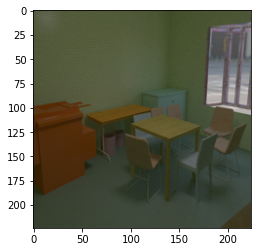

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


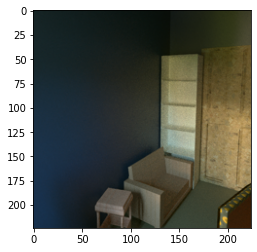

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


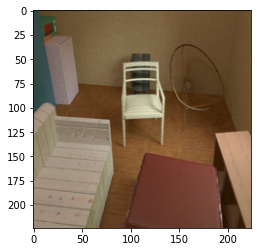

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


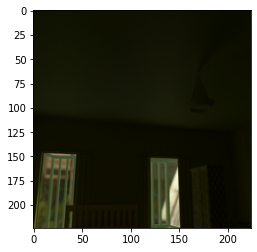

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


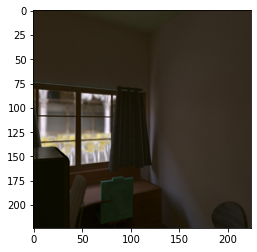

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


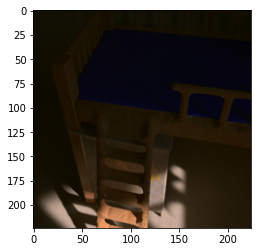

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


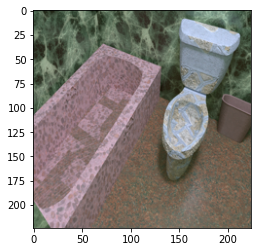

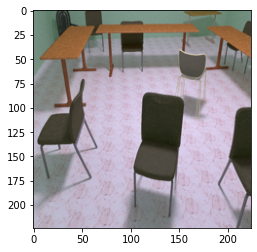

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


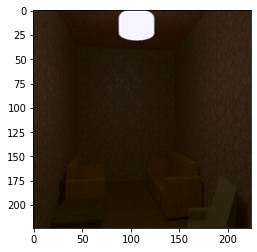

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


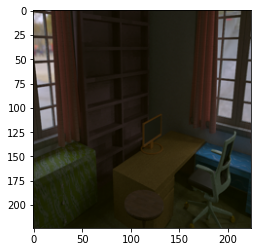

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    plt.imshow(inv_normalize(data[0][i]).permute(1,2,0))
    plt.show()